In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import friedmanchisquare, ttest_rel
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm  import SVC
from sklearn.ensemble  import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from itertools import combinations

In [23]:
df = pd.read_csv('winequality-red.csv')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [24]:
df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [26]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


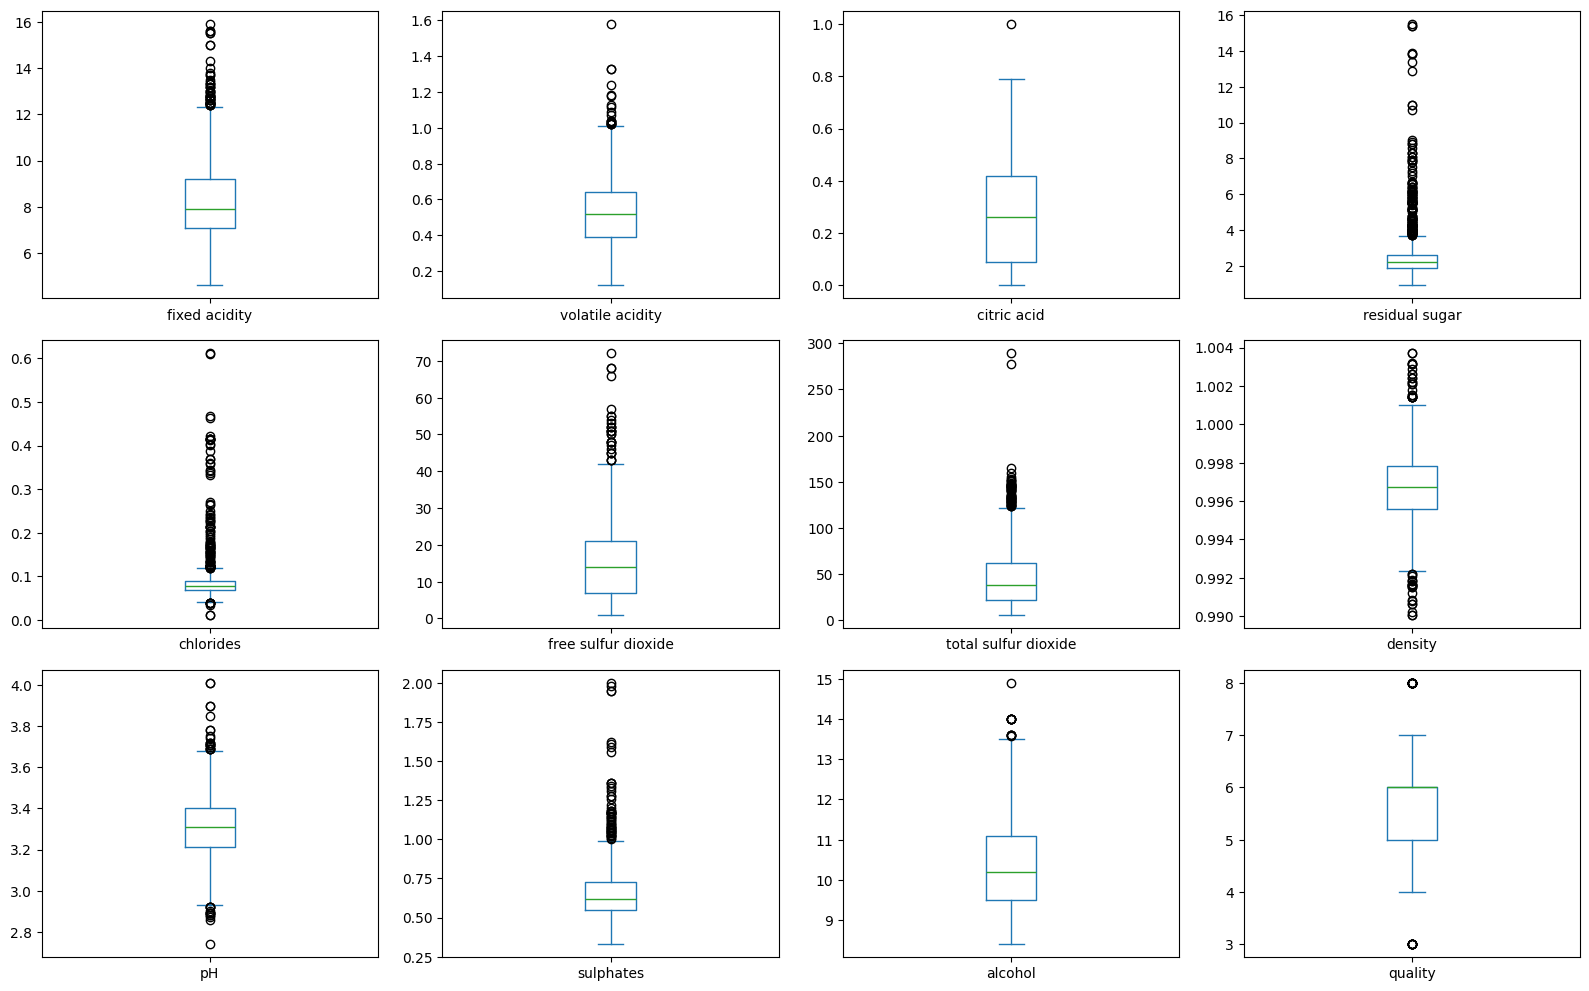

In [27]:
df.plot(kind='box', subplots=True, layout=(3, 4), figsize=(16, 10), sharex=False, sharey=False)
plt.tight_layout()
plt.show()

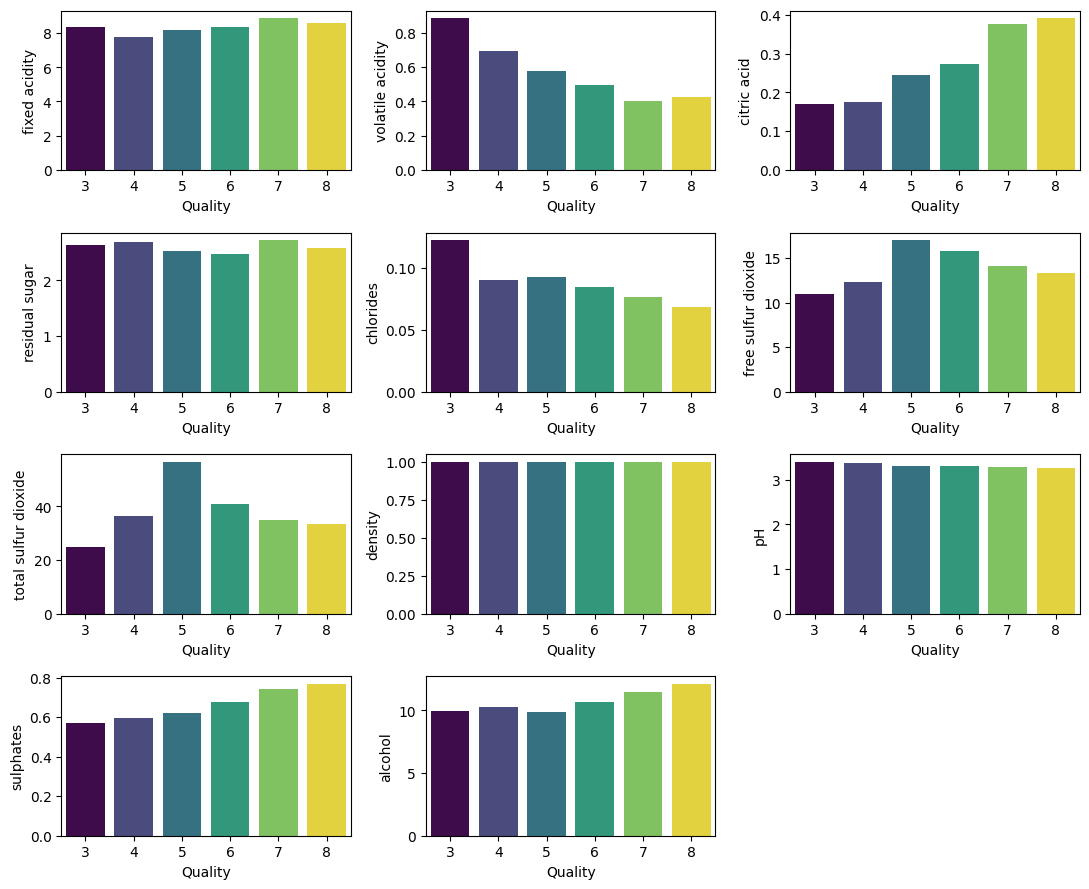

In [28]:
plt.figure(figsize=(11,9))
plotnumber=1

cont_col = [col for col in df.columns if col != 'quality']

for column in cont_col:
    ax=plt.subplot(4,3,plotnumber)
    sns.barplot(x='quality', y=df[column], data=df, palette = 'viridis', errorbar=None, hue='quality', legend=False)
    
    plt.xlabel('Quality')
    plt.ylabel(column)
    plotnumber+=1
plt.tight_layout()

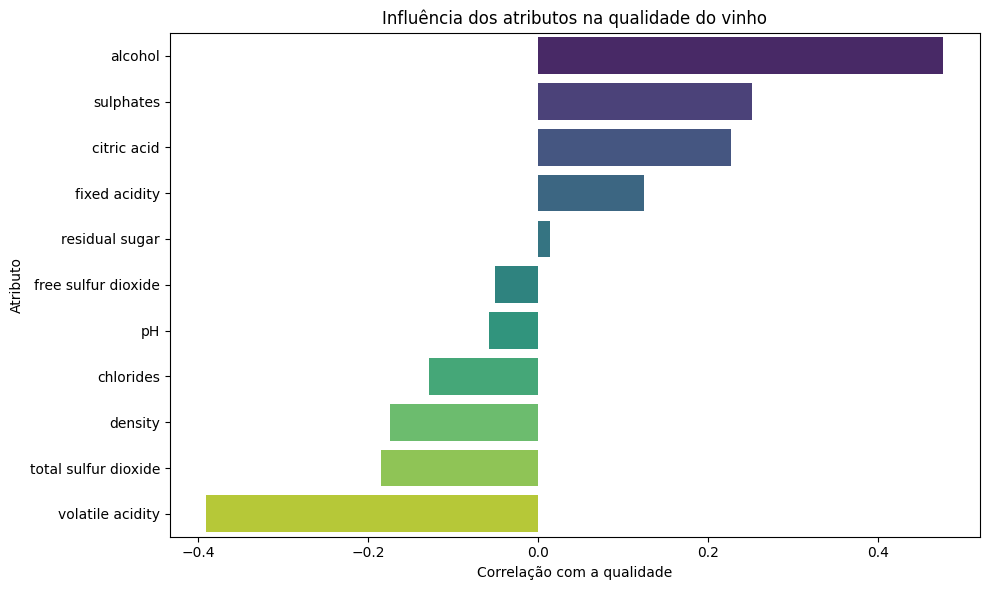

In [29]:
correlations = df.corr(numeric_only=True)['quality'].drop('quality').sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.values, y=correlations.index, palette='viridis', hue=correlations.index, legend=False)
plt.xlabel('Correlação com a qualidade')
plt.ylabel('Atributo')
plt.title('Influência dos atributos na qualidade do vinho')
plt.tight_layout()
plt.show()

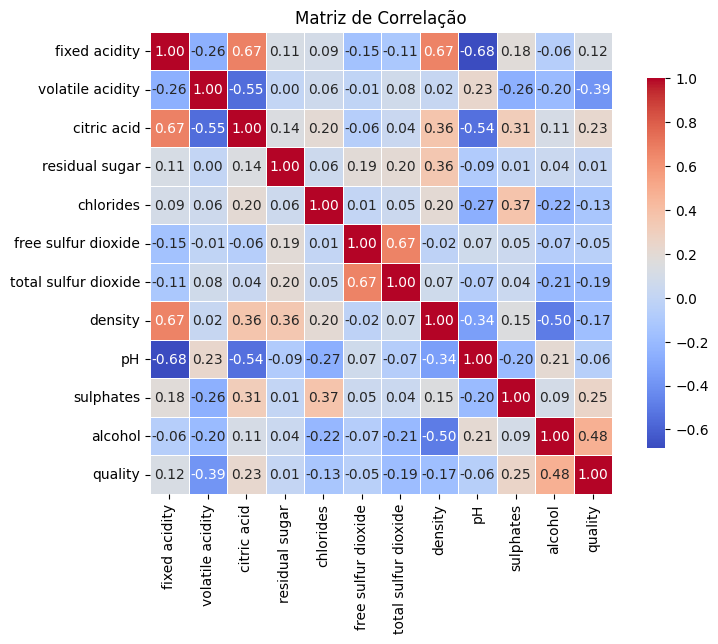

In [30]:
crr = df.corr()
plt.figure(figsize=(9, 6))
sns.heatmap(crr, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, linewidths=0.5)
plt.title('Matriz de Correlação')
plt.show()

In [31]:
df.quality.unique()

array([5, 6, 7, 4, 8, 3])

In [32]:
df = df.replace({'quality' : {
        8 : 'Good',
        7 : 'Good',
        6 : 'Middle',
        5 : 'Middle',
        4 : 'Bad',
        3 : 'Bad',
        }}
)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,Middle
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,Middle
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,Middle
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,Middle
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,Middle


In [33]:
X_temp = df.drop(columns='quality')
y = df.quality
y

0       Middle
1       Middle
2       Middle
3       Middle
4       Middle
         ...  
1594    Middle
1595    Middle
1596    Middle
1597    Middle
1598    Middle
Name: quality, Length: 1599, dtype: object

In [34]:
scaler = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_temp)
X = pd.DataFrame(scaler, columns=X_temp.columns)
X.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,0.329171,0.279329,0.270976,0.112247,0.125988,0.209506,0.142996,0.490211,0.449695,0.196496,0.311228
std,0.154079,0.122644,0.194801,0.096570,0.078573,0.147326,0.116238,0.138571,0.121564,0.101501,0.163949
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.221239,0.184932,0.090000,0.068493,0.096828,0.084507,0.056537,0.406021,0.370079,0.131737,0.169231
50%,0.292035,0.273973,0.260000,0.089041,0.111853,0.183099,0.113074,0.490455,0.448819,0.173653,0.276923
75%,0.407080,0.356164,0.420000,0.116438,0.130217,0.281690,0.197880,0.570117,0.519685,0.239521,0.415385
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [36]:
best_estimators = {}
cv_distributions = {}

In [37]:
parameters = {
    'C' : [0.001, 0.01, 0.1, 1.0, 10, 100, 1000],
    'class_weight' : ['balanced'],
    'solver' : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky']
}


lr = LogisticRegression()
lr_cv = GridSearchCV(estimator=lr, param_grid=parameters, cv=20).fit(X_train, y_train)

print('Tuned hyper parameters : ', lr_cv.best_params_)
print('accuracy : ', lr_cv.best_score_)

best_lr = lr_cv.best_estimator_
best_estimators['LogisticRegression'] = best_lr
y_pred_lr = lr_cv.predict(X_test)

lr_score = best_lr.score(X_test, y_test)
print('LogisticRegression score : ', lr_score)

Tuned hyper parameters :  {'C': 0.1, 'class_weight': 'balanced', 'solver': 'liblinear'}
accuracy :  0.8281779661016948
LogisticRegression score :  0.85


In [38]:
parameters = {
    'n_estimators': [50, 150, 500],
    'criterion':    ['gini','entropy','log_loss'],
    'max_features': ['sqrt','log2']
}


rf = RandomForestClassifier(n_jobs=-1)
rf_cv = GridSearchCV(estimator=rf, param_grid=parameters, cv=10).fit(X_train, y_train)

print('Tuned hyper parameters : ', rf_cv.best_params_)
print('accuracy : ', rf_cv.best_score_)

best_rf = rf_cv.best_estimator_
best_estimators['RandomForest'] = best_rf
y_pred_rf = rf_cv.predict(X_test)

rf_score = best_rf.score(X_test, y_test)
print('RandomForestClassifier score : ', rf_score)

Tuned hyper parameters :  {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 150}
accuracy :  0.8640476190476191
RandomForestClassifier score :  0.8775


In [39]:
parameters = {
    'C' : [0.001, 0.01, 0.1, 1.0, 10, 100],
    'gamma' : [0.001, 0.01, 0.1, 1.0, 10, 100],
    'class_weight' : ['balanced'],
}

svc = SVC()
svc_cv = GridSearchCV(estimator=svc, param_grid=parameters, cv=5).fit(X_train, y_train)

print('Tuned hyper parameters : ', svc_cv.best_params_)
print('accuracy : ', svc_cv.best_score_)

best_svc = svc_cv.best_estimator_
best_estimators['SVC'] = best_svc
y_pred_svc = svc_cv.predict(X_test)

svc_score = best_svc.score(X_test, y_test)
print('SVC score : ', svc_score)

Tuned hyper parameters :  {'C': 10, 'class_weight': 'balanced', 'gamma': 100}
accuracy :  0.8523849372384937
SVC score :  0.8875


In [40]:
parameters = {
    'criterion': ['gini', 'entropy'],
    'splitter' : ['best', 'random'],
    'max_depth': list(np.arange(4, 30, 1)),
    'min_samples_split':[2, 5]
}


dt = DecisionTreeClassifier()
dt_cv = GridSearchCV(estimator=dt, param_grid=parameters, cv=20).fit(X_train, y_train)

print('Tuned hyper parameters : ', dt_cv.best_params_)
print('accuracy : ', dt_cv.best_score_)

best_dt = dt_cv.best_estimator_
best_estimators['DecisionTreeClassifier'] = best_dt
y_pred_dt = dt_cv.predict(X_test)

dt_score = best_dt.score(X_test, y_test)
print('DecisionTreeClassifier score : ', dt_score)

Tuned hyper parameters :  {'criterion': 'gini', 'max_depth': np.int64(4), 'min_samples_split': 2, 'splitter': 'random'}
accuracy :  0.8315254237288136
DecisionTreeClassifier score :  0.8525


In [41]:
parameters = {
    'n_neighbors' : list(np.arange(3, 50, 2)),
    'weights': ['uniform', 'distance'],
    'p' : [1, 2, 3, 4]
}


knn = KNeighborsClassifier()
knn_cv = GridSearchCV(estimator=knn, param_grid=parameters, cv=20).fit(X_train, y_train)

print('Tuned hyper parameters : ', knn_cv.best_params_)
print('accuracy : ', knn_cv.best_score_)

best_knn = knn_cv.best_estimator_
best_estimators['KNeighborsClassifier'] = best_knn
y_pred_knn = knn_cv.predict(X_test)

knn_score = best_knn.score(X_test, y_test)
print('KNeighborsClassifier score : ', knn_score)

Tuned hyper parameters :  {'n_neighbors': np.int64(21), 'p': 1, 'weights': 'distance'}
accuracy :  0.8615677966101696
KNeighborsClassifier score :  0.875


c:\Users\lcvf1\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [42]:
parameters = {
    'hidden_layer_sizes': [(50,), (100,)],
    'activation':  ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001] 
}


mlp = MLPClassifier(max_iter=500)
mlp_cv = GridSearchCV(estimator=mlp, param_grid=parameters, cv=10).fit(X_train, y_train)

print('Tuned hyper parameters : ', mlp_cv.best_params_)
print('accuracy : ', mlp_cv.best_score_)

best_mlp = mlp_cv.best_estimator_
best_estimators['MLPClassifier'] = best_mlp
y_pred_mlp = mlp_cv.predict(X_test)

mlp_score = best_mlp.score(X_test, y_test)
print('DecisionTreeClassifier score : ', mlp_score)

c:\Users\lcvf1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\lcvf1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\lcvf1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\lcvf1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the opti

Tuned hyper parameters :  {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'solver': 'adam'}
accuracy :  0.8365476190476191
DecisionTreeClassifier score :  0.8425


c:\Users\lcvf1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [43]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=30, random_state=42)

In [44]:
for name, est in best_estimators.items():
    scores = cross_val_score(
        est, X_train, y_train,
        cv=cv,
        scoring='accuracy',
        n_jobs=-1
    )
    cv_distributions[name] = scores
    print(f"{name}: mean={scores.mean():.4f} ± {scores.std():.4f}")

LogisticRegression: mean=0.8225 ± 0.0109
RandomForest: mean=0.8582 ± 0.0155
SVC: mean=0.8526 ± 0.0111
DecisionTreeClassifier: mean=0.8187 ± 0.0171
KNeighborsClassifier: mean=0.8553 ± 0.0163
MLPClassifier: mean=0.8351 ± 0.0152


In [45]:
stat, p = friedmanchisquare(*cv_distributions.values())
print(f"Friedman χ²={stat:.3f}, p={p:.4f}")
if p < 0.05:
    print("→ Há diferença significativa em pelo menos um par de algoritmos")

Friedman χ²=503.570, p=0.0000
→ Há diferença significativa em pelo menos um par de algoritmos


In [ ]:
alpha = 0.05
m = len(cv_distributions)
comparisons = list(combinations(cv_distributions.keys(), 2))
for a, b in comparisons:
    s1 = cv_distributions[a]
    s2 = cv_distributions[b]
    stat, pval = ttest_rel(s1, s2)
    p_adj = min(pval * len(comparisons), 1.0)
    print(f"{a} vs {b}: t={stat:.3f}, p={pval:.4f}, p_adj={p_adj:.4f}",
        "→ dif. sign." if p_adj<alpha else "→ não dif.")

LogisticRegression vs RandomForest: t=-27.874, p=0.0000, p_adj=0.0000 → dif. sign.
LogisticRegression vs SVC: t=-24.524, p=0.0000, p_adj=0.0000 → dif. sign.
LogisticRegression vs DecisionTreeClassifier: t=2.617, p=0.0098, p_adj=0.1469 → não dif.
LogisticRegression vs KNeighborsClassifier: t=-24.314, p=0.0000, p_adj=0.0000 → dif. sign.
LogisticRegression vs MLPClassifier: t=-10.527, p=0.0000, p_adj=0.0000 → dif. sign.
RandomForest vs SVC: t=4.827, p=0.0000, p_adj=0.0001 → dif. sign.
RandomForest vs DecisionTreeClassifier: t=23.647, p=0.0000, p_adj=0.0000 → dif. sign.
RandomForest vs KNeighborsClassifier: t=2.861, p=0.0048, p_adj=0.0725 → não dif.
RandomForest vs MLPClassifier: t=17.352, p=0.0000, p_adj=0.0000 → dif. sign.
SVC vs DecisionTreeClassifier: t=19.602, p=0.0000, p_adj=0.0000 → dif. sign.
SVC vs KNeighborsClassifier: t=-2.142, p=0.0338, p_adj=0.5072 → não dif.
SVC vs MLPClassifier: t=11.403, p=0.0000, p_adj=0.0000 → dif. sign.
DecisionTreeClassifier vs KNeighborsClassifier: t=-